In [175]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import collections
import seaborn as sns
# We shall also use two additional files  - credits to Andrew Elliott and Javier Pardo Diaz:
# import extraNetwork
import communityDetection as comDet
import networkx.generators.community as nxc
%matplotlib inline

In [176]:
#data: https://toreopsahl.com/datasets/#loaddatasets
#This dataset contains an intra-organizational networks from a consulting company (46 employees) 
#These networks was used by Cross and Parker (2004).
#In the first network, the ties are differentiated on a scale from 0 to 5 in terms of frequency of information or advice requests 
#“Please indicate how often you have turned to this person for information or advice on work-related topics in the past three months”
#0: I Do Not Know This Person; 
#1: Never; 
#2: Seldom; 
#3: Sometimes; 
#4: Often;
#5:Very Often.

df = pd.read_csv('data/Cross_Parker-Consulting_info.txt',sep=' ',header=None)
df = df.drop(columns=0).rename(columns = {1:'v1',2:'v2',3:'w'})

#remove edges with w=1 (because it means they never use them)
df = df[df['w']!=1]
display(df.head())

,v1,v2,w
0,1,3,5
1,1,8,3
2,1,9,3
3,1,12,3
4,1,15,2


In [177]:
#attributes
#gender (1: male; 2: female)
gender = pd.read_csv('data/Cross_Parker-Consulting-gender.txt',sep=' ',header=None)
gender = gender.drop(columns=46).transpose().rename(columns={0:'gender'})
gender['gender'] = gender['gender'].apply(lambda x: 'male' if x==1 else 'female')
display(gender.head(3))


,gender
0,male
1,male
2,female


In [178]:
#location
#1: Boston; 
#2: London; 
#3: Paris; 
#4: Rome; 
#5: Madrid; 
#6: Oslo; 
#7: Copenhagen
def location(x):
    if x == 1:
        name = 'Boston'
    elif x == 2:
        name = 'London'
    elif x == 3:
        name = 'Paris'
    elif x == 4:
        name = 'Rome'
    elif x == 5:
        name = 'Madrid'
    elif x == 6:
        name = 'Oslo'
    else:
        name = 'Copenhagen'
    return name

loc = pd.read_csv('data/Cross_Parker-Consulting-location.txt',sep=' ',header=None)
loc = loc.drop(columns=46).transpose().rename(columns={0:'loc'})
loc['loc'] = loc['loc'].apply(lambda x: location(x))
display(loc.head(3))


,loc
0,Paris
1,Boston
2,Copenhagen


In [179]:
#organisational level 
#1 Research Assistant; 
#2: Junior Consultant; 
#3: Senior Consultant; 
#4: Managing Consultant; 
#5: Partner, 

def orglevel(x):
    if x == 1:
        level = '1. Research Assistant'
    elif x == 2:
        level = '2. Junior Consultant'
    elif x == 3:
        level = '3. Senior Consultant'
    elif x == 4:
        level = '4. Managing Consultant'
    else:
        level = '5. Partner'
    return level

org = pd.read_csv('data/Cross_Parker-Consulting-orglevel.txt',sep=' ',header=None)
org = org.drop(columns=46).transpose().rename(columns={0:'org'})
org['org'] = org['org'].apply(lambda x: orglevel(x))
display(org.head(3))


,org
0,3. Senior Consultant
1,4. Managing Consultant
2,1. Research Assistant


In [180]:
# region 
#1: Europe; 
#2: USA
reg = pd.read_csv('data/Cross_Parker-Consulting-region.txt',sep=' ',header=None)
reg = reg.drop(columns=46).transpose().rename(columns={0:'reg'})
reg['reg'] = reg['reg'].apply(lambda x: 'Europe' if x==1 else 'USA')
display(reg.head(3))


,reg
0,Europe
1,USA
2,Europe


In [181]:
#merge these attributes together to create vertex list too
nodes = pd.concat([gender,loc,reg,org], axis=1)
nodes['v'] = nodes.index + 1
v = set(nodes['v'])
display(nodes.head())

,gender,loc,reg,org,v
0,male,Paris,Europe,3. Senior Consultant,1
1,male,Boston,USA,4. Managing Consultant,2
2,female,Copenhagen,Europe,1. Research Assistant,3
3,male,Rome,Europe,4. Managing Consultant,4
4,male,Boston,USA,4. Managing Consultant,5


# Descriptive Statistics

In [182]:
print('Number of vertices:', len(v))
print('Number of edges:', len(df))

Number of vertices: 46
Number of edges: 523


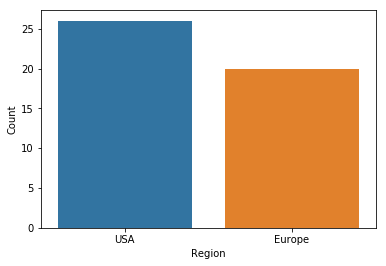

In [183]:
ax = sns.countplot(x="reg", data=nodes, order = nodes['reg'].value_counts().index)
plt.xlabel('Region')
plt.ylabel('Count')
plt.savefig('figs/region.png')
plt.show()

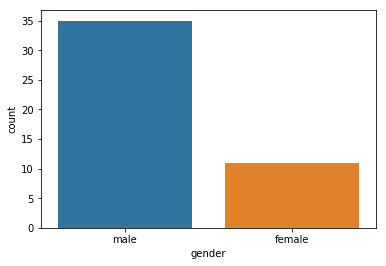

In [184]:
#bar charts
ax = sns.countplot(x="gender", data=nodes)

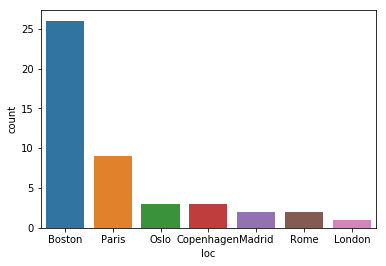

In [185]:
ax = sns.countplot(x="loc", data=nodes, order = nodes['loc'].value_counts().index)
#majority is boston!

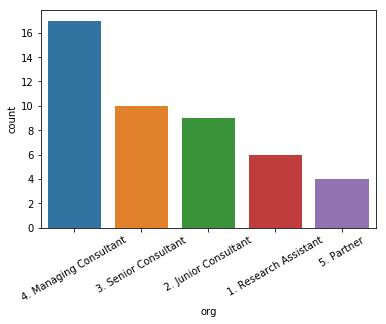

In [186]:
ax = sns.countplot(x="org", data=nodes, order = nodes['org'].value_counts().index)
plt.xticks(rotation=30)
plt.show()

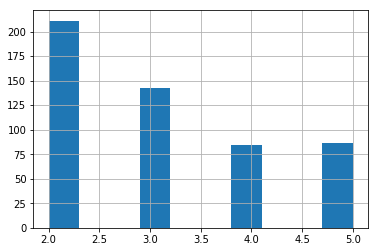

In [187]:
df['w'].hist()

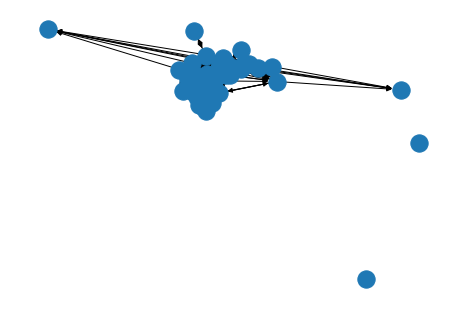

In [189]:
# directed, unweighted graph
G = nx.DiGraph()

#ignore weights
tuples = [tuple(x) for x in df[['v1','v2']].values]
# G.add_weighted_edges_from(tuples)
G.add_edges_from(tuples)
G.add_nodes_from(v)

nx.draw(G)

In [119]:
print('ave in degree:',sum(dict(G.in_degree()).values())/len(dict(G.in_degree()).values()))

ave in degree: 11.886363636363637
ave out degree: 11.886363636363637


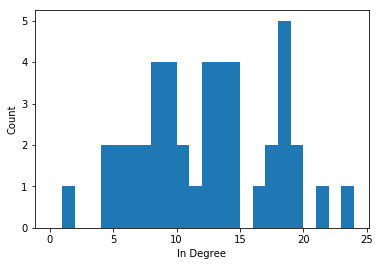

In [113]:
#degree distribution
plt.hist(list(dict(G.in_degree()).values()),bins=range(25))
plt.xlabel('In Degree')
plt.ylabel('Count')
plt.savefig('figs/indegree.png')
plt.show()

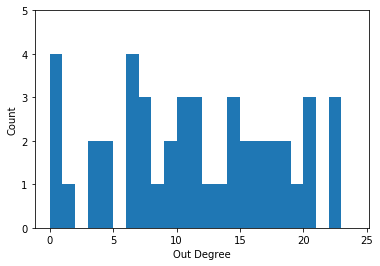

In [190]:
plt.hist(list(dict(G.out_degree()).values()),bins=range(25))
plt.xlabel('Out Degree')
plt.ylabel('Count')
plt.yticks(range(6))
plt.savefig('figs/outdegree.png')
plt.show()

In [195]:
#Community detection

#make graph undirected
#For community detection we start with a connected network. To find the largest connected component of a graph use the following command:
graph1=max(nx.connected_component_subgraphs(G.to_undirected()), key=len)

graph1Bet = comDet.betweenComDetect(graph1)
print(comDet.modularity(graph1,graph1Bet))

0.33120346437251597


In [196]:
v1 = graph1Bet.keys()
com = set(graph1Bet.values())
missing_v = v-v1
print('Number of communities in connected subgraph:',len(com))
print('Number of nodes disconnected:',len(missing_v))
print('Disconnected nodes:',missing_v)


Number of communities in connected subgraph: 3
Number of nodes disconnected: 2
Disconnected nodes: {24, 30}


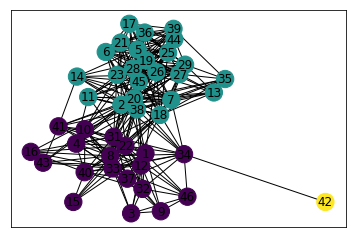

In [197]:
#subgraph communities
nx.draw_networkx(graph1,nodelist=v1,node_color=[graph1Bet[x] for x in v1])

In [198]:
comm_tab = pd.DataFrame.from_dict(collections.Counter(graph1Bet.values()),orient='index')


In [199]:
for v in missing_v:
    G.remove_node(v)

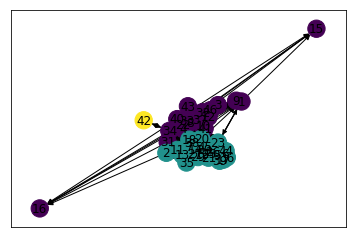

In [200]:
nx.draw_networkx(G,nodelist=v1,node_color=[graph1Bet[x] for x in v1])

In [201]:
#merge the communities back to the nodes
df_comm = pd.DataFrame.from_dict(graph1Bet, orient='index')
df_comm = df_comm.reset_index().rename(columns = {0:'community','index':'v'})
display(df_comm.head())

,v,community
0,1,0
1,3,0
2,4,0
3,8,0
4,9,0


In [202]:
nodes = nodes.merge(df_comm, on = 'v')

In [203]:
display(nodes.head())

,gender,loc,reg,org,v,community
0,male,Paris,Europe,3. Senior Consultant,1,0
1,male,Boston,USA,4. Managing Consultant,2,1
2,female,Copenhagen,Europe,1. Research Assistant,3,0
3,male,Rome,Europe,4. Managing Consultant,4,0
4,male,Boston,USA,4. Managing Consultant,5,1


In [204]:
df = df.merge(df_comm, left_on = 'v1', right_on = 'v')
df = df.merge(df_comm, left_on = 'v2', right_on = 'v')

In [205]:
df = df.drop(columns = ['v_x','v_y'])
display(df.head())

,v1,v2,w,community_x,community_y
0,1,3,5,0,0
1,8,3,2,0,0
2,9,3,2,0,0
3,12,3,2,0,0
4,32,3,2,0,0


In [206]:
g = pd.crosstab(nodes['community'],nodes['gender'],normalize='index')
g = g.rename(columns={1:'male',2:'female'})
display(g)

gender,female,male
community,,
0,0.210526,0.789474
1,0.250000,0.750000
2,0.000000,1.000000


In [207]:
r = pd.crosstab(nodes['community'],nodes['reg'],normalize='index')
r = r.rename(columns={1:'Europe',2:'USA'})
display(r)

reg,Europe,USA
community,,
0,1.0,0.0
1,0.0,1.0
2,1.0,0.0


In [208]:
o = pd.crosstab(nodes['community'],nodes['org'],normalize='index')
o = o.rename(columns={1:'Research Assistant',2:'Junior Consultant', 
                      3:'Senior Consultant',4:'Managing Consultant',
                      5:'Partner'})
display(o)

org,1. Research Assistant,2. Junior Consultant,3. Senior Consultant,4. Managing Consultant,5. Partner
community,,,,,
0,0.105263,0.210526,0.157895,0.421053,0.105263
1,0.041667,0.208333,0.291667,0.375000,0.083333
2,1.000000,0.000000,0.000000,0.000000,0.000000


In [209]:
l = pd.crosstab(nodes['community'],nodes['loc'],normalize='index')
l = l.rename(columns={1:'Boston',2:'London',3:'Paris',4:'Rome', 
                      5:'Madrid',6:'Oslo',7:'Copenhagen'})
display(l)

loc,Boston,Copenhagen,London,Madrid,Oslo,Paris,Rome
community,,,,,,,
0,0.0,0.157895,0.052632,0.052632,0.157895,0.473684,0.105263
1,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


In [210]:
comm_tab.merge(r,left_index = True, right_index = True)

,0,Europe,USA
0,19,1.0,0.0
1,24,0.0,1.0
2,1,1.0,0.0


Community structures seem to be based on region (USA vs Europe). In line with working practices. Clustering coefficient should reflect that

In [211]:
nx.transitivity(G)

0.5317647058823529

In [212]:
#density: team cohesion
nx.density(G)

0.27642706131078226

In [213]:
#reciprocity
#low reciprocity = flow of info is one way (potentially hierarchical)
#high reciprocity = mutual working relationship
# import networkx.algorithms.reciprocity as r

nx.reciprocity(G)

0.768642447418738

In [214]:
#average distance
nx.average_shortest_path_length(G)

1.849894291754757

# Monte Carlo (random)
Hypothesis: density and reciprocity will be much smaller than random graph model?

In [60]:
graph=G
n=graph.number_of_nodes()

#probability of edge creation (directed)
p = graph.number_of_edges()/float(n*(n-1))
rand_graphs = 999

In [61]:
p #same as density

0.27642706131078226

In [67]:
t=[]
r=[]
s=[]

#create random graphs
for run in range(rand_graphs):
    rand_G= nx.fast_gnp_random_graph(n,p, directed=True, seed=None) #Erdos renyi graph. Fix number of edges?
    t.append(nx.transitivity(rand_G))
    r.append(nx.reciprocity(rand_G))
    s.append(nx.average_shortest_path_length(rand_G))

graph_t=nx.transitivity(graph)
graph_rec=nx.reciprocity(graph)
graph_s=nx.average_shortest_path_length(graph)

t.append(graph_t)
r.append(graph_rec)
s.append(graph_s)

rank_t = sorted(t).index(graph_t) #lower
rank_r = sorted(r).index(graph_rec) #higher
rank_s = sorted(s).index(graph_s) #lower

print('transitivity rank:', rank_t+1, ', percentile:', (rank_t+1)/(rand_graphs+1))
print('reciprocity rank:', rank_r+1, ', percentile:', (rank_r+1)/(rand_graphs+1))
print('average shortest path rank:', rank_s+1, ', percentile:', (rank_s+1)/(rand_graphs+1))


transitivity rank: 1000 , percentile: 1.0
reciprocity rank: 1000 , percentile: 1.0
average shortest path rank: 1000 , percentile: 1.0


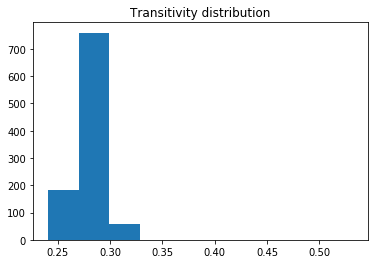

In [65]:
plt.hist(t)
plt.title('Transitivity distribution')
plt.show()

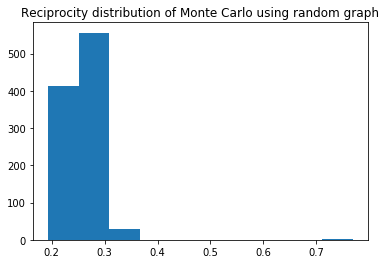

In [39]:
plt.hist(r)
plt.title('Reciprocity distribution of Monte Carlo using random graph')
plt.show()

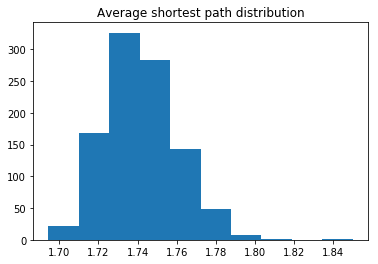

In [66]:
plt.hist(s)
plt.title('Average shortest path distribution')
plt.show()

In [40]:
#what happens when changing the weight threshold?

In [41]:
#check burt: what is a hierarchical structure??

# Monte Carlo (conf model)

Hypothesis: reciprocity will be much larger than random configuration model?

Doesn't make sense to do density because if you are preserving degree sequence, density will always be the same.

In [228]:
graph=G
n=graph.number_of_nodes()

#in and out degree sequence
din=list(dict(graph.in_degree()).values())
dout=list(dict(graph.out_degree()).values())

rand_graphs = 999

In [229]:
t=[]
r=[]
s=[]
#create random graphs
for run in range(rand_graphs):
    rand_G = nx.directed_configuration_model(in_degree_sequence=din, out_degree_sequence=dout, create_using=None, seed=None)
    rand_G = nx.DiGraph(rand_G)
    try:
        s.append(nx.average_shortest_path_length(rand_G))
    except:
        #if the graph is disconnected, reinitialise a new graph. Part of the MC test for me is to only take connected graphs
        rand_G = nx.directed_configuration_model(in_degree_sequence=din, out_degree_sequence=dout, create_using=None, seed=None)
        rand_G = nx.DiGraph(rand_G)
        s.append(nx.average_shortest_path_length(rand_G))
        
    t.append(nx.transitivity(rand_G))
    r.append(nx.reciprocity(rand_G))
    

graph_t=nx.transitivity(graph)
graph_rec=nx.reciprocity(graph)
graph_s=nx.average_shortest_path_length(graph)

t.append(graph_t)
r.append(graph_rec)
s.append(graph_s)

rank_t = sorted(t).index(graph_t) #lower
rank_r = sorted(r).index(graph_rec) #higher
rank_s = sorted(s).index(graph_s) #lower

print('transitivity rank:', rank_t+1, ', percentile:', (rank_t+1)/(rand_graphs+1))
print('reciprocity rank:', rank_r+1, ', percentile:', (rank_r+1)/(rand_graphs+1))
print('average shortest path rank:', rank_s+1, ', percentile:', (rank_s+1)/(rand_graphs+1))


transitivity rank: 1000 , percentile: 1.0
reciprocity rank: 1000 , percentile: 1.0
average shortest path rank: 1000 , percentile: 1.0


In [156]:
print(len(t),len(r),len(s))

1000 1000 1000


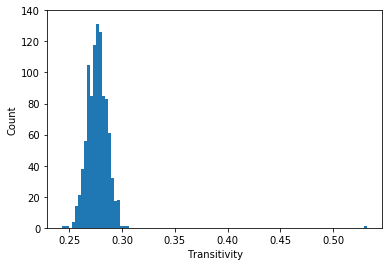

In [240]:
plt.hist(t, bins = 100)
# plt.title('Transitivity distribution of Monte Carlo using configuration model')
plt.xlabel('Transitivity')
plt.ylabel('Count')
# plt.xticks()
plt.ylim(0,140)
plt.savefig('figs/t_conf.png')
plt.show()

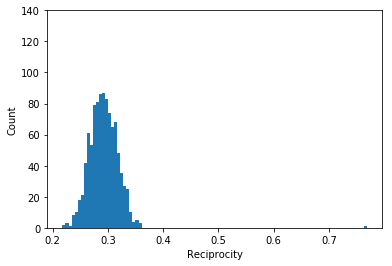

In [241]:
plt.hist(r, bins = 100)
# plt.title('Reciprocity distribution of Monte Carlo using configuration model')
plt.xlabel('Reciprocity')
plt.ylabel('Count')
plt.ylim(0,140)
plt.savefig('figs/r_conf.png')
plt.show()

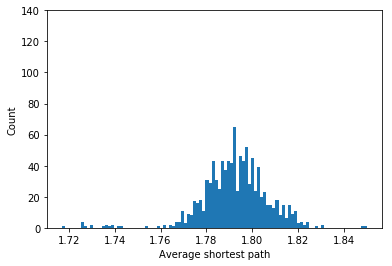

In [244]:
plt.hist(s, bins = 100)
# plt.title('Average shortest path distribution of Monte Carlo using configuration model')
plt.xlabel('Average shortest path')
plt.ylabel('Count')
plt.ylim(0,140)
plt.savefig('figs/s_conf.png')
plt.show()

# Stochastic block model

In [245]:
from collections import Counter

In [246]:
p = []

for r in range(max(graph1Bet.values())+1):
    edge_prob = []
    for s in range(max(graph1Bet.values())+1):
        cr_s = df[(df['community_x']==r) & (df['community_y']==s)]
        cx = df_comm[df_comm['community']==r]['v']
        cy = df_comm[df_comm['community']==s]['v']
        n = len(set(list(cx)+list(cy)))
        
        if n == 1:
            pr_s = 0
        else:
            pr_s = len(cr_s)/float(n*(n-1))
#         print(r,s,pr_s)
        edge_prob.append(pr_s)
        
#     print('\n')
    p.append(edge_prob)
print(p)

[[0.391812865497076, 0.017718715393133997, 0.002631578947368421], [0.02159468438538206, 0.572463768115942, 0.0], [0.002631578947368421, 0.0, 0]]


In [247]:
graph=G
n=graph.number_of_nodes()

#size of groups
sizes = list(Counter(graph1Bet.values()).values())

rand_graphs = 999 

In [248]:
t=[]
r=[]
s=[]

#create random graphs
for run in range(rand_graphs):
    rand_G= nxc.stochastic_block_model(sizes,p, directed=True, seed=None)
    try:
        s.append(nx.average_shortest_path_length(rand_G))
    except:
        #if the graph is disconnected, reinitialise a new graph. Part of the MC test for me is to only take connected graphs
        rand_G = nx.directed_configuration_model(in_degree_sequence=din, out_degree_sequence=dout, create_using=None, seed=None)
        rand_G = nx.DiGraph(rand_G)
        try: #try again
            s.append(nx.average_shortest_path_length(rand_G))
        except:
            #if the graph is disconnected, reinitialise a new graph. Part of the MC test for me is to only take connected graphs
            rand_G = nx.directed_configuration_model(in_degree_sequence=din, out_degree_sequence=dout, create_using=None, seed=None)
            rand_G = nx.DiGraph(rand_G)
            s.append(nx.average_shortest_path_length(rand_G))

    t.append(nx.transitivity(rand_G))
    r.append(nx.reciprocity(rand_G))

graph_t=nx.transitivity(graph)
graph_rec=nx.reciprocity(graph)
graph_s=nx.average_shortest_path_length(graph)

t.append(graph_t)
r.append(graph_rec)
s.append(graph_s)

rank_t = sorted(t).index(graph_t) #lower
rank_r = sorted(r).index(graph_rec) #higher
rank_s = sorted(s).index(graph_s) #lower

print('transitivity rank:', rank_t+1, ', percentile:', (rank_t+1)/(rand_graphs+1))
print('reciprocity rank:', rank_r+1, ', percentile:', (rank_r+1)/(rand_graphs+1))
print('average shortest path rank:', rank_s+1, ', percentile:', (rank_s+1)/(rand_graphs+1))


transitivity rank: 990 , percentile: 0.99
reciprocity rank: 1000 , percentile: 1.0
average shortest path rank: 890 , percentile: 0.89


In [150]:
print(len(t),len(r),len(s))

1000 1000 1000


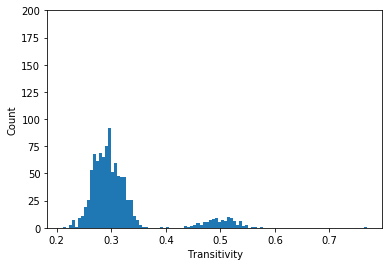

In [259]:
plt.hist(r, bins = 100)
# plt.title('Reciprocity distribution of Monte Carlo using stochastic block model')
plt.xlabel('Transitivity')
plt.ylabel('Count')
plt.ylim(0,200)
plt.savefig('figs/r_block.png')
plt.show()

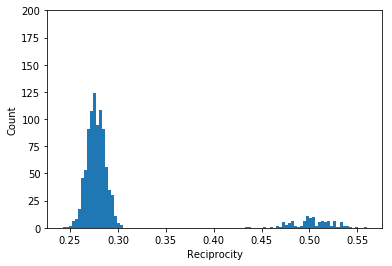

In [258]:
plt.hist(t, bins = 100)
# plt.title('transitivity distribution of Monte Carlo using stochastic block model')
plt.xlabel('Reciprocity')
plt.ylabel('Count')
plt.ylim(0,200)
plt.savefig('figs/t_block.png')
plt.show()

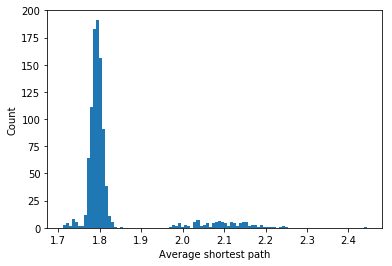

In [257]:
plt.hist(s, bins = 100)
# plt.title('Average shortest path distribution of Monte Carlo using stochastic block model')
plt.xlabel('Average shortest path')
plt.ylabel('Count')
plt.ylim(0,200)
plt.savefig('figs/s_block.png')
plt.show()